In [1]:
import import_ipynb
from milestone2 import *

from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline

# Constants
ainit = 1.0e-8
xinit = math.log(ainit)
xend = np.log(1.0)

nk = 100
ketamax = 3000.0
kmin = .5/(η_spline(0.0)[0])
kmax = ketamax/(η_spline(0.0)[0])#*m2Mpc

ks = np.exp(np.linspace(np.log(kmin), np.log(kmax), num=nk))

lmaxint = 6
npar = 6 + lmaxint

ntotal = 1000
print('kmin:', kmin)
print('kmax:', kmax)
print('ck/hpdτ:', c*k/(getHPrime(xinit)*get_funct_der(xinit, τspl, 1)[0]))
print('ck/hpdτ:', c*k/(getHPrime(xinit)*τ2spl(xinit)[0]))
print(ks)

importing Jupyter notebook from milestone2.ipynb
importing Jupyter notebook from milestone1.ipynb
The surface of last scattering occured at x_* = -6.98 and z_* = 1068.80.

The half-way point of recombination occured at x_r = -7.16 and z_r = 1291.14.

Using only the Saha equation, the half-way point of recombination occured at x_r = -7.23 and z_r = 1380.38.

kmin: 1.1342349974496965e-27
kmax: 6.805409984698179e-24
ck/hpdτ: -17495608082478.834
ck/hpdτ: -17415198378693.49
[1.13423500e-27 1.23841495e-27 1.35216388e-27 1.47636070e-27
 1.61196504e-27 1.76002470e-27 1.92168370e-27 2.09819115e-27
 2.29091088e-27 2.50133200e-27 2.73108038e-27 2.98193125e-27
 3.25582288e-27 3.55487157e-27 3.88138800e-27 4.23789510e-27
 4.62714753e-27 5.05215296e-27 5.51619531e-27 6.02286014e-27
 6.57606235e-27 7.18007642e-27 7.83956942e-27 8.55963714e-27
 9.34584337e-27 1.02042630e-26 1.11415288e-26 1.21648828e-26
 1.32822324e-26 1.45022109e-26 1.58342451e-26 1.72886270e-26
 1.88765946e-26 2.06104177e-26 2.25034

In [2]:
# Returns the time at which tight coupling ends.
# Either when (dτ < 10) OR (c*k/(Hp*dt) > .1) OR (x > x(recomb start))
def getTCtime(k):
    xstartrec = -math.log(1.0 + 1630.4)
    x = xinit
    
    while x < xstartrec:
        x = x + 1.0e-1
        hp = getHPrime(x)
        dτ = τ2spl(x)[0]
        #dτ = get_funct_der(x, τspl, 1)
        
        if (abs(dτ) < 10.0 or abs(c*k/(hp*dτ)) > .1 or x > xstartrec):
            xtc = x
            break
        
    '''
    n = 1000
    for i in range(n):
        x = x + (xstartrec - xinit)/n
        
        #get_funct_der(x-array, spline, derivative order) 
        #if ( (get_funct_der(x, τspl, 1) < 10.0 and c*k/(getHPrime(x)*get_funct_der(x, τspl, 1)) > 0) or x > xstartrec ):
        if (abs(k/(getHPrime(x)*get_funct_der(x, τspl, 1)) >= 1.0/10.0) and (abs(get_funct_der(x, τspl, 1)) <= 10.0)) or x >= xstartrec:
            TCtime = x
            print(TCtime)
            print(i)
            break
    '''
    return xtc

In [35]:
def yTCderivs(x, t):
    dydx = np.zeros(7)
    
    k0 = kcurrent
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    #dτ = get_funct_der(x, τspl, 1)
    dτ = τ2spl(x)[0]
    #ddτ = get_funct_der(x, τspl, 2)
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*math.exp(x))
    Θ2 = -20.0*c*k0*y[6]/(45.0*hp*dτ)
    ψ = -y[4] - 12.0*H0**2.0*Ωr*Θ2/(c**2.0*k0**2.0*math.exp(2.0*x))
    
    # δ    = [0]
    # δb   = [1]
    # v    = [2]
    # vb   = [3]
    # dΦ   = [4]
    # θ0   = [5]
    # θ1   = [6]    
    
    # dΦ
    dydx[4] = ψ - ((c**2.0)*(k0**2.0)/3.0*hp**2.0) + ((H0**2.0)/(2.0*hp**2.0))*(Ωm/math.exp(x)*y[0] + Ωb/math.exp(x)*y[1] + 4.0*Ωr/(math.exp(x)**2.0)*y[5])
    
    # dθ0
    dydx[5] = -c*k0*y[6]/hp - dydx[4]
    
    q = (-((1.0 - R)*dτ + (1.0 + R)*ddτ)*(3.0*y[6] + y[3]) - (c*k0/hp)*ψ + (1.0 - dhp/hp)*(c*k0/hp)*(-y[5] + 2.0*Θ2) - ((c*k0/hp)*dydx[5]))/((1.0 + R)*dτ + (dhp/hp) - 1.0)
    
    # dvb
    dydx[3] = (-y[3] - c*k0*ψ/hp + R*(q + c*k0*(-y[5] + 2.0*Θ2)/hp - c*k0*ψ/hp))/(1.0 + R)
    
    #dθ1
    dydx[6] = (q - dydx[3])/3.0
    
    # dv
    dydx[2] = -y[2] - c*k0*ψ/hp
    
    # dδ
    dydx[0] = c*k0*y[2]/hp - 3.0*dydx[4]
        
    # dδb
    dydx[1] = c*k0*y[3]/hp - 3.0*dydx[4]
    
    return dydx

In [36]:
def yderivs(x, t):
    dydx = np.zeros(npar)
    
    k0 = kcurrent
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    #dτ = get_funct_der(x, τspl, 1)
    dτ = τ2spl(x)[0]
    #ddτ = get_funct_der(x, τspl, 2)
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*math.exp(x))
    ψ = -y[4] - 12.0*(H0/(c*k0*math.exp(x)))**2.0 *Ωr*y[7]
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # Φ  = [4]
    # θ0 = [5]
    # θ1 = [6]
    # Θl = [7->11]
    
    # dΦ
    dydx[4] = ψ - c**2.0*k0**2.0*y[4]/(3.0*hp**2.0) + (H0**2.0/(2.0*hp**2.0))*(((Ωm*y[0])/math.exp(x)) + ((Ωb*y[1])/math.exp(x)) + ((4.0*Ωr*y[5])/(math.exp(2.0*x))))
    
    # dδ
    dydx[0] = c*k0*y[2]/hp - 3.0*dydx[4]

    # dδb
    dydx[1] = c*k0*y[3]/hp - 3.0*dydx[4]
    
    # dv
    dydx[2] = -y[2] - c*k0*ψ/hp

    # dvb
    dydx[3] = -y[3] - c*k0*ψ/hp + dτ*R*(3.0*y[6] + y[3])
    
    # dθ0
    dydx[5] = -c*k0*y[6]/hp - dydx[4]

    # dθ1
    dydx[6] = c*k0*y[5]/(3.0*hp) - 2.0*c*k0/(3.0*hp)*y[7] + c*k0/(3.0*hp)*ψ + dτ*(y[6] + (1.0/3.0)*y[3])
    
    # dΘ2
    dydx[7] = (2.0*c*k0/(5.0*hp))*y[6] - (3.0*c*k0/(5.0*hp))*y[8] + dτ*(y[7] - .1*y[7])
    
    # dΘ3->5
    #for l in range(3, lmaxint - 1):
    for l in range(3, lmaxint - 1):
        dydx[5 + l] = ((l*c*k0/hp*y[5 + l - 1])/(2.0*l + 1.0)) - (((l + 1.0)*c*k0/hp*y[5 + l + 1])/((2.0*l + 1.0))) + (dτ*y[5 + l])
    
    # dΘ6
    dydx[npar - 1] = c*k0/hp*y[npar - 2] - ((c*(lmaxint + 1)*y[npar - 1])/(hp*η_spline(x))) + dτ*y[npar - 1]
    
    return dydx

In [37]:
# Initialize and solve the Boltzmann and Einstein equations
Θ = np.zeros(shape = (ntotal, lmaxint, nk))
dΘ = np.zeros(shape = (ntotal, lmaxint, nk))

δ = np.zeros(shape = (ntotal, nk))
δb = np.zeros(shape = (ntotal, nk))

v = np.zeros(shape = (ntotal, nk))
vb = np.zeros(shape = (ntotal, nk))
dvb = np.zeros(shape = (ntotal, nk))

Φ = np.zeros(shape = (ntotal, nk))
dΦ = np.zeros(shape = (ntotal, nk))

Ψ = np.zeros(shape = (ntotal, nk))
dΨ = np.zeros(shape = (ntotal, nk))

# Set up initial conditions for Boltzmann and Einstin equations
for i in range(nk):    
    Ψ[0, i] = -2.0/3.0
    Φ[0, i] = -Ψ[0, i]#1.0
    
    δ[0, i] = 3.0/2.0*Φ[0, i]
    δb[0, i] = δ[0, i]
    
    v[0, i] = c*ks[i]*Φ[0, i]/(2.0*getHPrime(xinit))
    vb[0, i] = v[0, i]
    
    Θ[0, 0, i] = 1.0/2.0*Φ[0, i]
    Θ[0, 1, i] = -c*ks[i]*Φ[0, i]/(6.0*getHPrime(xinit))
    
    
    #Θ[0, 2, i] = -20.0*c*ks[i]*Θ[0, 1, i]/(45.0*getHPrime(xinit)*get_funct_der(xinit, τspl, 1))
    Θ[0, 2, i] = -20.0*c*ks[i]*Θ[0, 1, i]/(45.0*getHPrime(xinit)*τ2spl(xinit)[0])
    
    
    
    for l in range(3, lmaxint):
        #Θ[0, l, i] = -l*c*ks[i]*Θ[0, l - 1, i]/((2.0*l + 1.0)*getHPrime(xinit)*get_funct_der(xinit, τspl, 1))
        Θ[0, l, i] = -l*c*ks[i]*Θ[0, l - 1, i]/((2.0*l + 1.0)*getHPrime(xinit)*τ2spl(xinit)[0])


In [38]:
gg = np.zeros(shape = (10, 3))
gg[0, :] = 1.0
print(gg[0, :])

[1. 1. 1.]


In [39]:
import timeit
start = timeit.default_timer()

# Integrate Perturbation Equations
y = np.zeros(npar)
ytc = np.zeros(7) #y tight coupling - ytc

x_grid_during = np.linspace(XSTART, XEND, GRID_DURING)
x_grid_after = np.linspace(XEND, X0, GRID_AFTER, endpoint=True)
x_grid = np.linspace(math.log(1.0e-8), math.log(1.0), 1000)

#Propogate each k-mode independently
for k in range(nk):
    if k%10==0:
        print('------------------------------')
        print('k:', k)
        print('xtc:', xtc)
    kcurrent = ks[k]

    #Initialize equation set for tight coupling
    ytc[0] = δ[0, k]
    ytc[1] = δb[0, k]
    ytc[2] = v[0, k]
    ytc[3] = vb[0, k]
    ytc[4] = Φ[0, k]
    ytc[5] = Θ[0, 0, k]
    ytc[6] = Θ[0, 1, k]
    
    #Find the time at which tight couplint (TC) is assumed
    #and integrate equations to that time
    xtc = getTCtime(kcurrent)
    ntight = 500
    xtight = np.linspace(xinit, xtc, ntight, endpoint=True)
    x_full = np.linspace(xtc, xend, CONFORMAL_N - ntight, endpoint=True)
    
    sol_tight = solve_ivp(yTCderivs, [xinit, xtc], ytc, t_eval=xtight)#, rtol=1e-6, atol=1e-6)
    
    y_after_tc = sol_tight.y[:, -1]
    
    
    ##ψ = -y[4] - 12.0*(H0/(c*k0*math.exp(x)))**2.0 *Ωr*y[7]
    ##ψ_after_tc
    
    
    for j in range(7):
        y[j] = y_after_tc[j]

    #y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*τ2spl(xtc)[0])
    
    for l in range(2, lmaxint):
        #y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
        y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*τ2spl(xtc)[0])
    
    #tmpΘ2 = y[8]
    
    
    sol_full = solve_ivp(yderivs, [xtc, xend], y, t_eval=x_full, rtol=1e-6, atol=1e-6)
    
    #y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*τ2spl(xtc)[0])
    
    for l in range(2, lmaxint):
        #y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
        y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*τ2spl(xtc)[0])
        
    
    cur_δ = np.concatenate((sol_tight.y[0], sol_full.y[0]))
    cur_δb = np.concatenate((sol_tight.y[1], sol_full.y[1]))
    cur_v = np.concatenate((sol_tight.y[2], sol_full.y[2]))
    cur_vb = np.concatenate((sol_tight.y[3], sol_full.y[3]))
    cur_Φ = np.concatenate((sol_tight.y[4], sol_full.y[4]))
    cur_Θ0 = np.concatenate((sol_tight.y[5], sol_full.y[5]))
    cur_Θ1 = np.concatenate((sol_tight.y[6], sol_full.y[6]))
    #cur_Θ2 = np.concatenate((tmpΘ2, y[8]))
    
    
    δ[:, k] = cur_δ
    δb[:, k] = cur_δb
    v[:, k] = cur_v
    vb[:, k] = cur_vb
    Φ[:, k] = cur_Φ
    Θ[:, 0, k] = cur_Θ0
    Θ[:, 1, k] = cur_Θ1
    
stop = timeit.default_timer()
print('Time:', stop - start)

------------------------------
k: 0
xtc: -7.320680743952364


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [30]:
δ_spl = RectBivariateSpline(x_grid, ks, δ)
δb_spl = RectBivariateSpline(x_grid, ks, δb)
v_spl = RectBivariateSpline(x_grid, ks, v)
vb_spl = RectBivariateSpline(x_grid, ks, vb)
Φ_spl = RectBivariateSpline(x_grid, ks, Φ)
Ψ_spl = RectBivariateSpline(x_grid, ks, Ψ)
Θ0_spl = RectBivariateSpline(x_grid, ks, Θ[:, 0, :])
Θ1_spl = RectBivariateSpline(x_grid, ks, Θ[:, 1, :])
Θ2_spl = RectBivariateSpline(x_grid, ks, Θ[:, 2, :])

In [32]:
def plot(kvals):
    #kmpc = '{:.3g}'.format(kval*(1.0e6*3.08567758e16))
    #data_δ = δ_spl(x_grid, kval)[:, 0]
    #data_δb = δb_spl(x_grid, kval)[:, 0]
    #data_v = v_spl(x_grid, kval)[:, 0]
    #data_vb = vb_spl(x_grid, kval)[:, 0]
    #data_Φ = Φ_spl(x_grid, kval)[:, 0]
    #data_Ψ = Ψ_spl(x_grid, kval)[:, 0]
    #data_Θ0 = Θ0_spl(x_grid, kval)[:, 0]
    #data_Θ1 = Θ1_spl(x_grid, kval)[:, 0]
    #data_Θ2 = Θ2_spl(x_grid, kval)[:, 0]
    
    clr = ['b', 'darkorange', 'g']
    
    lb = str('{:04.2f}'.format(1.0)) + ' / Mpc'
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(19, 17))
    
    axs[0, 0].set_title('Density Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 0].set_yscale('log')
    for i in range(len(kvals)):
        data_δ = δ_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(data_δ), color=clr[i], label=lb)
        data_δb = δb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, data_δb, color=clr[i], ls='--')
    #plt.plot(x_grid, np.abs(3.0*data_Θ0), label='δR')
    axs[0, 0].legend()
    
    
    axs[0, 1].set_title('Velocity Perturbations')# k = ' + str(kmpc) + '/ Mpc')
    axs[0, 1].set_yscale('log')
    for i in range(len(kvals)):
        data_v = v_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_v), color=clr[i], ls='--', label=lb)
        data_vb = vb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_vb), color=clr[i])
    #plt.plot(x_grid, np.abs(-3.0*data_Θ1),label='|vR|')
    axs[0, 1].legend()
    
    
    axs[1, 0].set_title('Θ0')
    for i in range(len(kvals)):
        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]
        axs[1, 0].plot(x_grid, np.abs(3.0*data_Θ0), color=clr[i], label=lb)
    axs[1, 0].legend()
    
    
    axs[1, 1].set_title('Θ1')
    for i in range(len(kvals)):
        data_Θ1 = Θ1_spl(x_grid, kvals[i])[:, 0]
        axs[1, 1].plot(x_grid, np.abs(data_Θ1), color=clr[i], label=lb)
    axs[1, 1].legend()
    
    
    axs[2, 0].set_title('Gravitational Potential')
    for i in range(len(kvals)):
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 0].plot(x_grid, data_Φ, color=clr[i], label=lb)
    axs[2, 0].legend()
    
    axs[2, 1].set_title('Psi')
    for i in range(len(kvals)):
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 1].plot(x_grid, data_Ψ, color=clr[i], label=lb)
    axs[2,1].legend()
    
    fig.tight_layout()
    plt.show()

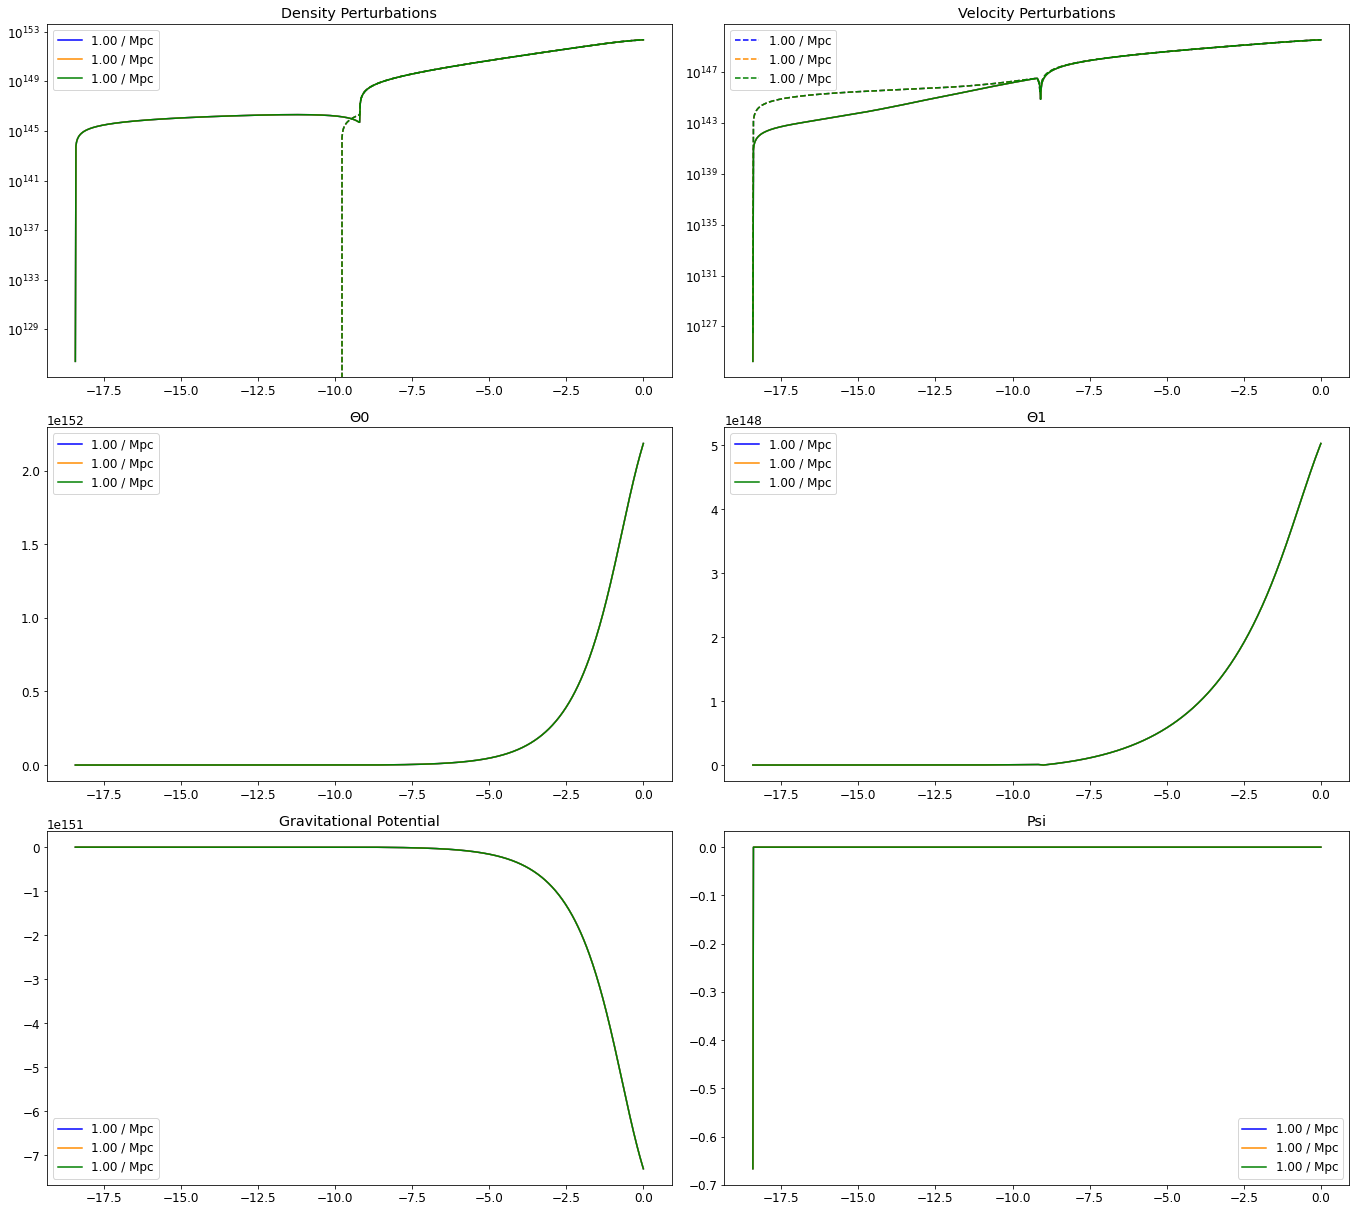

In [33]:
kvals = [.001, .01, .1]
plot(kvals)

In [ ]:
'''
    for i in range(GRID_DURING):

        #Integrate from xinit until the end of TC using the TC equations     
        sol_tight = solve_ivp(yTCderivs, [xinit, xtc], ytc)#, t_eval=xtight, rtol=1e-6, atol=1e-6)
        
        y_after_tc = sol_tight.y[:, -1]
        
        δ[i][k] = y_after_tc[0]
        δb[i][k] = y_after_tc[1]
        v[i][k] = y_after_tc[2]
        vb[i][k] = y_after_tc[3]
        Φ[i][k] = y_after_tc[4]
        Θ[i][0][k] = y_after_tc[5]
        Θ[i][1][k] = y_after_tc[6]
        Θ[i][2][k] = -20.0*c*kcurrent*Θ[i][1][k]/(45.0*getHPrime(x_grid_during[i])*get_funct_der(x_grid_during[i], τspl, 1))
                                                  
        for l in range(3, lmaxint):
            Θ[i][l][k] = (l / (2.0*l + 1.0))*(c*kcurrent/(getHPrime(x_grid_during[i])*get_funct_der(x_grid_during[i], τspl, 1)))*Θ[i][l - 1][k]
            
        Ψ[i][k] = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*kcurrent**2.0*math.exp(x_grid_during[i])**2.0)
        
    #Set up variables for integration from the end of tight coupling until today
    for j in range(7):
        y[j] = y_after_tc[j]

    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(x_grid_during[-1])*get_funct_der(x_grid_during[-1], τspl, 1))

    for l in range(2, lmaxint):
        y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(x_grid_during[-1])*get_funct_der(x_grid_during[-1], τspl, 1))
    
    for i in range(GRID_AFTER):
        sol_full = solve_ivp(yderivs, [xtc, xend], y, t_eval=x_full, rtol=1e-6, atol=1e-6)
        
        y_after_tc2 = sol_full.y[:, -1]
        
        δ[i][k] = y_after_tc2[0]
        δb[i][k] = y_after_tc2[1]
        v[i][k] = y_after_tc2[2]
        vb[i][k] = y_after_tc2[3]
        Φ[i][k] = y_after_tc2[4]
        Θ[i][0][k] = y_after_tc2[5]
        Θ[i][1][k] = y_after_tc2[6]
        Θ[i][2][k] = -20.0*c*kcurrent*Θ[i][1][k]/(45.0*getHPrime(x_grid_after[i])*get_funct_der(x_grid_after[i], τspl, 1))
                                                  
        for l in range(3, lmaxint):
            Θ[i][l][k] = y_after_tc2[5 + l]
            
        Ψ[i][k] = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*kcurrent**2.0*math.exp(x_grid_after[i])**2.0)
        
    cur_δ = np.concatenate((sol_tight.y[0], sol_full.y[0]))
    cur_δb = np.concatenate((sol_tight.y[1], sol_full.y[1]))
    cur_v = np.concatenate((sol_tight.y[2], sol_full.y[2]))
    cur_vb = np.concatenate((sol_tight.y[3], sol_full.y[3]))
    cur_Φ = np.concatenate((sol_tight.y[4], sol_full.y[4]))
    cur_Θ0 = np.concatenate((sol_tight.y[5], sol_full.y[5]))
    cur_Θ1 = np.concatenate((sol_tight.y[6], sol_full.y[6]))

    cur_Θ2 = np.concatenate((sol_tight.y[0], sol_full.y[0]))
'''
    
      
'''
    cur_δ = np.concatenate((sol_tight.y[0], sol_full.y[0]))
    cur_δb = np.concatenate((sol_tight.y[1], sol_full.y[1]))
    cur_v = np.concatenate((sol_tight.y[2], sol_full.y[2]))
    cur_vb = np.concatenate((sol_tight.y[3], sol_full.y[3]))
    cur_Φ = np.concatenate((sol_tight.y[4], sol_full.y[4]))
    cur_Θ0 = np.concatenate((sol_tight.y[5], sol_full.y[5]))
    cur_Θ1 = np.concatenate((sol_tight.y[6], sol_full.y[6]))
    
    cur_Θ2 = np.concatenate((sol_tight.y[0], sol_full.y[0]))
    
    δ[:][k] = cur_δ
    δb[:][k] = cur_δb
    v[:][k] = cur_v
    vb[:][k] = cur_vb
    Φ[:][k] = cur_Φ
    Θ[:][0][k] = cur_Θ0
    Θ[:][1][k] = cur_Θ1
    Θ[:][2][k] = -20.0*c*kcurrent*Θ[i][1][k]/(45.0*getHPrime(x_grid[i])*get_funct_der(x_grid[i], τspl, 1))

    for l in range(3, lmaxint):
        Θ[:][l][k] = sol_full[5 + l]

    Ψ[:][k] = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*kcurrent**2.0*math.exp(x_grid[i])**2.0)
'''
    
'''
    for i in range(ntotal):
        
        if (i==1 and (x_grid[i] != xtc)):
            sol_full = solve_ivp(yderivs, [xtc, xend], y, t_eval=x_full, rtol=1e-6, atol=1e-6)
        else:
            sol_full = solve_ivp(yderivs, [xtc, xend], y, t_eval=x_full, rtol=1e-6, atol=1e-6)
        
        
        
        δ[i][k] = sol_full[0]
        δb[i][k] = sol_full[1]
        v[i][k] = sol_full[2]
        vb[i][k] = sol_full[3]
        Φ[i][k] = sol_full[4]
        Θ[i][0][k] = sol_full[5]
        Θ[i][1][k] = sol_full[6]
        Θ[i][2][k] = -20.0*c*kcurrent*Θ[i][1][k]/(45.0*getHPrime(x_grid[i])*get_funct_der(x_grid[i], τspl, 1))
                                                  
        for l in range(3, lmaxint):
            Θ[i][l][k] = sol_full[5 + l]
            
        Ψ[i][k] = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*kcurrent**2.0*math.exp(x_grid[i])**2.0)
        
        
        
        
        
        
        if x_grid[i] >= xtc:
            for i in range(7): y[i] = ytc[i]
                
            y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
            
            for l in range(2, lmaxint):
                y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
                
            break
'''

In [ ]:
# Integrate Perturbation Equations
y = np.zeros(npar)
#dydx = np.zeros(npar)
ytc = np.zeros(7) #y tight coupling - ytc


#Propogate each k-mode independently
for k in range(4):
    print('------------------------------')
    print('k:', k)
    kcurrent = ks[k]

    #Initialize equation set for tight coupling
    ytc[0] = δ[0][k]
    ytc[1] = δb[0][k]
    ytc[2] = v[0][k]
    ytc[3] = vb[0][k]
    ytc[4] = Φ[0][k]
    ytc[5] = Θ[0][0][k]
    ytc[6] = Θ[0][1][k]
    
    #Find the time at which tight couplint (TC) is assumed
    #and integrate equations to that time
    xtc = getTCtime(kcurrent)
    ntight = 500
    xtight = np.linspace(xinit, xtc, ntight)# endpoint=True)
    x_full = np.linspace(xtc, xend, CONFORMAL_N - ntight, endpoint=True)
    #Integrate from xinit until the end of TC using the TC equations 
    
    #print('xinit:', xinit)
    #print('xtc:', xtc)
    #print('Hp(xtc):', getHPrime(xtc))
    print('before')
    print('////////////////////////////////////////////////////////////')
    #print('xtight:', xtight)
    print(ytc)
    print('////////////////////////////////////////////////////////////')
    
    sol_tight = solve_ivp(yTCderivs, [xinit, xtc], ytc, t_eval=xtight, rtol=1e-6, atol=1e-6)
    
    y_after_tc = sol_tight.y[:, -1]
    
    #Set up variables for integration from the end of tight coupling until today
    for i in range(7): y[i] = y_after_tc[i]
        
    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
    
    for l in range(2, lmaxint):
        y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
    
    sol_full = solve_ivp(yderivs, [xtc, xend], y, t_eval=x_full, rtol=1e-6, atol=1e-6)
    
    cur_δ = np.concatenate((sol_tight.y[0], sol_full.y[0]))
    cur_δb = np.concatenate((sol_tight.y[1], sol_full.y[1]))
    cur_v = np.concatenate((sol_tight.y[2], sol_full.y[2]))
    cur_vb = np.concatenate((sol_tight.y[3], sol_full.y[3]))
    cur_Φ = np.concatenate((sol_tight.y[4], sol_full.y[4]))
    cur_Θ0 = np.concatenate((sol_tight.y[5], sol_full.y[5]))
    cur_Θ1 = np.concatenate((sol_tight.y[6], sol_full.y[6]))
    
    cur_Θ2 = np.concatenate((sol_tight.y[0], sol_full.y[0]))
    
    δ[:][k] = cur_δ
    δb[:][k] = cur_δb
    v[:][k] = cur_v
    vb[:][k] = cur_vb
    Φ[:][k] = cur_Φ
    Θ[:][0][k] = cur_Θ0
    Θ[:][1][k] = cur_Θ1
    Θ[:][2][k] = -20.0*c*kcurrent*Θ[i][1][k]/(45.0*getHPrime(x_grid[i])*get_funct_der(x_grid[i], τspl, 1))

    for l in range(3, lmaxint):
        Θ[:][l][k] = sol_full[5 + l]

    Ψ[:][k] = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*kcurrent**2.0*math.exp(x_grid[i])**2.0)

    
    
    
    
    for i in range(ntotal):
        
        if (i==1 and (x_grid[i] != xtc)):
            sol_full = solve_ivp(yderivs, [xtc, xend], y, t_eval=x_full, rtol=1e-6, atol=1e-6)
        else:
            sol_full = solve_ivp(yderivs, [xtc, xend], y, t_eval=x_full, rtol=1e-6, atol=1e-6)
        
        
        
        δ[i][k] = sol_full[0]
        δb[i][k] = sol_full[1]
        v[i][k] = sol_full[2]
        vb[i][k] = sol_full[3]
        Φ[i][k] = sol_full[4]
        Θ[i][0][k] = sol_full[5]
        Θ[i][1][k] = sol_full[6]
        Θ[i][2][k] = -20.0*c*kcurrent*Θ[i][1][k]/(45.0*getHPrime(x_grid[i])*get_funct_der(x_grid[i], τspl, 1))
                                                  
        for l in range(3, lmaxint):
            Θ[i][l][k] = sol_full[5 + l]
            
        Ψ[i][k] = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*kcurrent**2.0*math.exp(x_grid[i])**2.0)
        
        
        
        
        
        
        if x_grid[i] >= xtc:
            for i in range(7): y[i] = ytc[i]
                
            y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
            
            for l in range(2, lmaxint):
                y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(xtc)*get_funct_der(xtc, τspl, 1))
                
            break

In [21]:
print(sol_tight.y[:, -1])

[ 1.50000000e+00  1.50000000e+00  4.73839087e-04  4.73839087e-04
  1.00000000e+00  5.00000000e-01 -1.57946362e-04]


In [10]:
xt = np.linspace(0, 10, 5)
print(xt[-1])

10.0


In [ ]:
'''
    ###for i in range(1, len(ytc)):
    ###    rng  = np.linspace(xinit, xtc, 100)
    ###    dydx = yTCderivs(rng[i], ytc, dydx)
    ###    temp = bsint.bsintegrate(yderivs, dydx, rng[i - 1], rng[i + 1], args = (kcurrent,))
    ###    #temp = odeint(yderivs, dydx, rng[(i-1):i+1])
    ###    dydx = temp[1]
    
    #Set up variables for integration from the end of tight coupling until today
    for i in range(7): y[i] = ytc[i]
    y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(xtc)*get_funct_der(xtc, τ2spl, 1))
    
    for o in range(3, lmaxint):
        y[5 + o] = -o*c*kcurrent*y[5 + o - 1]/((2.0*o + 1.0)*getHPrime(xtc)*get_funct_der(xtc, τ2spl, 1))

    for i in range(ntotal):#should be (ntotal)
        #Integrate equations from TC to today
        if ( (i == 0) and (xtc != xgrid[i]) ): #getting out of TC-mode
            TCrng = np.linspace(xtc, xgrid[i], 100)
            temp = odeint(yderivs, dydx, TCrng)
            dydx = temp[1]
            
        elif i > 0: #going onwards to today
            temp = odeint(yderivs, dydx, xgrid[(i-1):i+1])
            dydx = temp[1]
            
        #print('ylen: ', len(y))
        #print('   k: ', k)
        #print('   i: ', i)
        # Store variables at time step i in global variables
        δ[i][k] = y[0]
        δb[i][k] = y[1]
        v[i][k] = y[2]
        vb[i][k] = y[3]
        Φ[i][k] = y[4]
        
        for l in range(lmaxint): Θ[i][l][k] = y[5 + l]
        
        Ψ[i][k] = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*kcurrent**2.0*(math.exp(xgrid[i]))**2.0)
        
        # Store derivatives that are required for C_l estimation
        #yderivs(xgrid[i], y, dydx)
        dΦ[i][k] = dydx[4]
        dvb[i][k] = dydx[3]
        for b in range(lmaxint): dΘ[i][b][k] = dydx[5:5+lmaxint]
        dΦ[i][k] = -dydx[4] - (12.0*H0**2.0*Ωr*math.exp(-1.0*xgrid[i])*(-2.0*y[7] + dydx[7])/(c**2.0*kcurrent**2.0))
    '''

In [ ]:
klist = [0, 11, 29, 39, 84, 99]

plt.figure()
plt.plot(xη, δ[0:len(xη-1)][0])


In [2]:
import numpy as np

xx = np.zeros((3, 5))

yy= np.zeros(shape = (3, 5))
print(xx)
print('--0-----------')
print(yy)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
--0-----------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
